<a href="https://colab.research.google.com/github/LawTAGS/Deep-Learning-Classwork/blob/main/DL_VAE_Figures_Interpolation_Photos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loaded 2 images of shape (64, 64, 3)
Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 2839.1270
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 2842.9946
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 2835.8042
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 2833.6345
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 2830.8335
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 2828.3328
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 2826.0649
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 2823.1587
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 2818.1399
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 2815.8352
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 2810.5801
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 2801.2292
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 2794.2866
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 2783.6851
Epoch 1

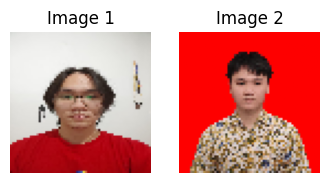

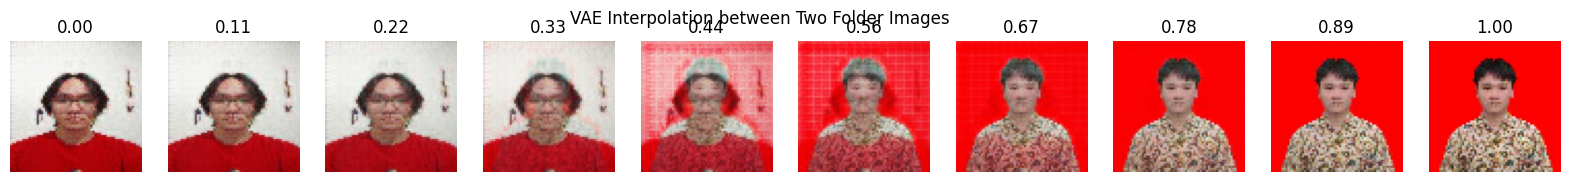

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ================================
# 0. Set random seeds for reproducibility
# ================================
np.random.seed(42)
tf.random.set_seed(42)

# ================================
# 1. Configuration & Hyperparameters
# ================================
FOLDER = './'
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
LATENT_DIM = 10
HIDDEN_CH = 32
EPOCHS = 500

# ================================
# 2. Utility: Load & preprocess images
# ================================
def load_and_prep(path):
    img = load_img(path, target_size=IMAGE_SIZE)
    arr = img_to_array(img) / 255.0
    return arr

file_list = [
    os.path.join(FOLDER, f)
    for f in os.listdir(FOLDER)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

X = np.stack([load_and_prep(p) for p in file_list], axis=0)
print("Loaded", X.shape[0], "images of shape", X.shape[1:])

# ===============================
# 3. Define the Convolutional VAE
# ===============================

class Encoder(Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv1 = layers.Conv2D(
            HIDDEN_CH, (3,3), strides=2, padding='same', activation='relu'
        )
        self.conv2 = layers.Conv2D(
            HIDDEN_CH * 2, (3,3), strides=2, padding='same', activation='relu'
        )
        self.flat = layers.Flatten()
        self.mu = layers.Dense(latent_dim, name='z_mean')
        self.lv = layers.Dense(latent_dim, name='z_log_var')

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        h = self.flat(x)
        return self.mu(h), self.lv(h)

class Decoder(Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.dense = layers.Dense(
            (IMAGE_SIZE[0] // 4) * (IMAGE_SIZE[1] // 4) * (HIDDEN_CH * 2),
            activation='relu'
        )
        self.reshape = layers.Reshape(
            (IMAGE_SIZE[0] // 4, IMAGE_SIZE[1] // 4, HIDDEN_CH * 2)
        )
        self.deconv1 = layers.Conv2DTranspose(
            HIDDEN_CH, (3,3), strides=2, padding='same', activation='relu'
        )
        self.deconv2 = layers.Conv2DTranspose(
            3, (3,3), strides=2, padding='same', activation='sigmoid'
        )

    def call(self, z):
        x = self.dense(z)
        x = self.reshape(x)
        x = self.deconv1(x)
        return self.deconv2(x)

class VAE(Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.enc = encoder
        self.dec = decoder

    def sample(self, mu, lv):
        eps = tf.random.normal(tf.shape(mu))
        return mu + tf.exp(0.5 * lv) * eps

    def call(self, x):
        mu, lv = self.enc(x)
        z = self.sample(mu, lv)
        x_hat = self.dec(z)

        recon_loss = tf.reduce_sum(
            tf.keras.losses.binary_crossentropy(x, x_hat),
            axis=[1, 2]
        )
        kl_loss = -0.5 * tf.reduce_sum(
            1 + lv - tf.square(mu) - tf.exp(lv),
            axis=1
        )
        self.add_loss(tf.reduce_mean(recon_loss + kl_loss))
        return x_hat

# ================================
# 4. Instantiate & compile the VAE
# ================================
encoder = Encoder(LATENT_DIM)
decoder = Decoder(LATENT_DIM)
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

# ================================
# 5. Train the VAE on your images
# ================================
vae.fit(X, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True)

# ================================
# 6. Build a standalone decoder/generator
# ================================
z_input = layers.Input(shape=(LATENT_DIM,))
x_output = decoder(z_input)
generator = Model(z_input, x_output)

# ================================
# 7. Pick any two images from the folder
# ================================
img1 = X[0]
img2 = X[1]

plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.title('Image 1')
plt.imshow(img1)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Image 2')
plt.imshow(img2)
plt.axis('off')
plt.show()

# ================================
# 8. Encode to get their latent means
# ================================
mu1, lv1 = encoder.predict(img1[None], verbose=0)[:2]
mu2, lv2 = encoder.predict(img2[None], verbose=0)[:2]

# ================================
# 9. Interpolate in latent space & generate
# ================================
n_steps = 10
alphas = np.linspace(0, 1, n_steps)
interp = []
for a in alphas:
    z = (1 - a) * mu1 + a * mu2
    xg = generator.predict(z, verbose=0)[0]
    interp.append(xg)

# ================================
# 10. Plot the morphing sequence
# ================================
plt.figure(figsize=(20, 2))
for i, frame in enumerate(interp):
    ax = plt.subplot(1, n_steps, i + 1)
    plt.imshow(frame)
    ax.axis('off')
    ax.set_title(f'{alphas[i]:.2f}')
plt.suptitle('VAE Interpolation between Two Folder Images')
plt.show()